In [1]:
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Practicalities of analysing biosignals
## Dr. Emlyn Clay <small>Head of Software Development Viditeck AG, Director of OpenVivo ltd.</small>

# Who am I?

+ Undergraduate Pharmacology (~2009) and doctorate of Pharamcology (2015)
+ Writing software since I was 18, professionally since 22
+ Web stuff (PHP), then VBscript, then MATLAB, then Python, then C ... etc
+ I spend most of my time programming and distributing biomedical equipment.

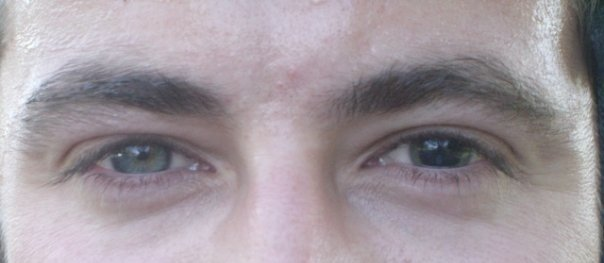

In [8]:
display.Image(filename='images/emlyn.jpg')

# Committee member of PyData London!

+ Monthly meetup for data science peoples using Python.
+ ~1800 members, regular 200 people meetups.
+ Yearly conference.
+ Advocate the Python community.


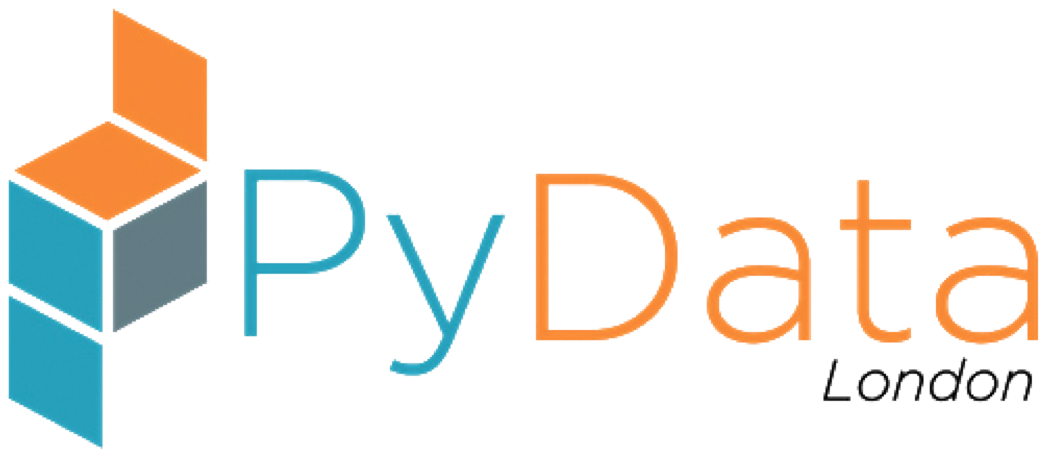

In [9]:
display.Image(filename='images/pydata_logo.png')

# Emlyn said ...

```
To: dgorissen@gmail.com
CC: "london@pydata.org" <london@pydata.org>
Subject: PyData London Call for Proposal - mind circulating?

Hello Dirk,

Do you mind forwarding the following call for proposal, below, for our PyData London Conference 2015 on June 19th - 21st to your members at The London Big-O group?

Thanks Dirk,

Emlyn

------

Hello Big Omegas,

...
```

# Dirk said ...

```
Date: Fri, 8 May 2015 22:00:53 +0100
Subject: Re: PyData London Call for Proposal - mind circulating?
To: Emlyn Clay <eclay101@gmail.com>

On the condition you come do a talk ;) I have a slot week of 17 August :)
_________________________________________
Dr. Dirk Gorissen
Research - Tech4Good - Flying Robots
Skype: dirk.gorissen
Mob: +44-7763-806-809
Twitter  : https://twitter.com/dirkgor
LinkedIn: http://www.linkedin.com/in/dirkgorissen
```

Bribery!

# Biosignals

Definitvely - 

> A biosignal is any signal in living organisms that can be measured and monitored, contiually or intermittently. Some are bioelectrical, but it may refer to both electrical and non-electrical signals.

Analysing them can be used to assess:

+ Healthy "normative" states
+ Disease states
+ Fundamental understanding

## Blood pressure

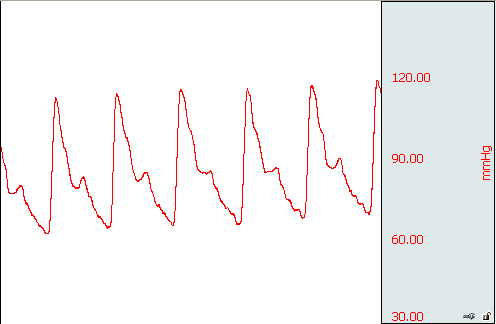

In [10]:
display.Image(filename='images/signal_blood-pressure.png')

## ECG

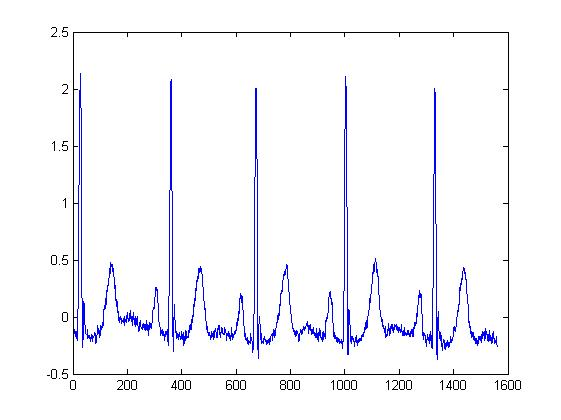

In [12]:
display.Image(filename='images/signal_ECG.jpeg')

## EEG

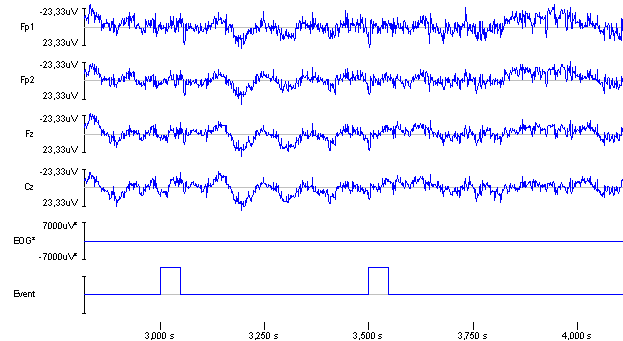

In [13]:
display.Image(filename='images/signal_EEG.png')

# What are we looking at today?

Practicalities.

+ Record biosignals
+ Storing them
+ Process them
+ Analyse them

# Recording biosignals

Things you are going to need -

+ Sensor
+ Amplifier
+ Analogue to Digital Convertor
+ Storage media

## Sensors

+ A thing that attaches to the person,
+ Possibly a box that is powering and conditioning the signal
+ Something that connects to your amplifier

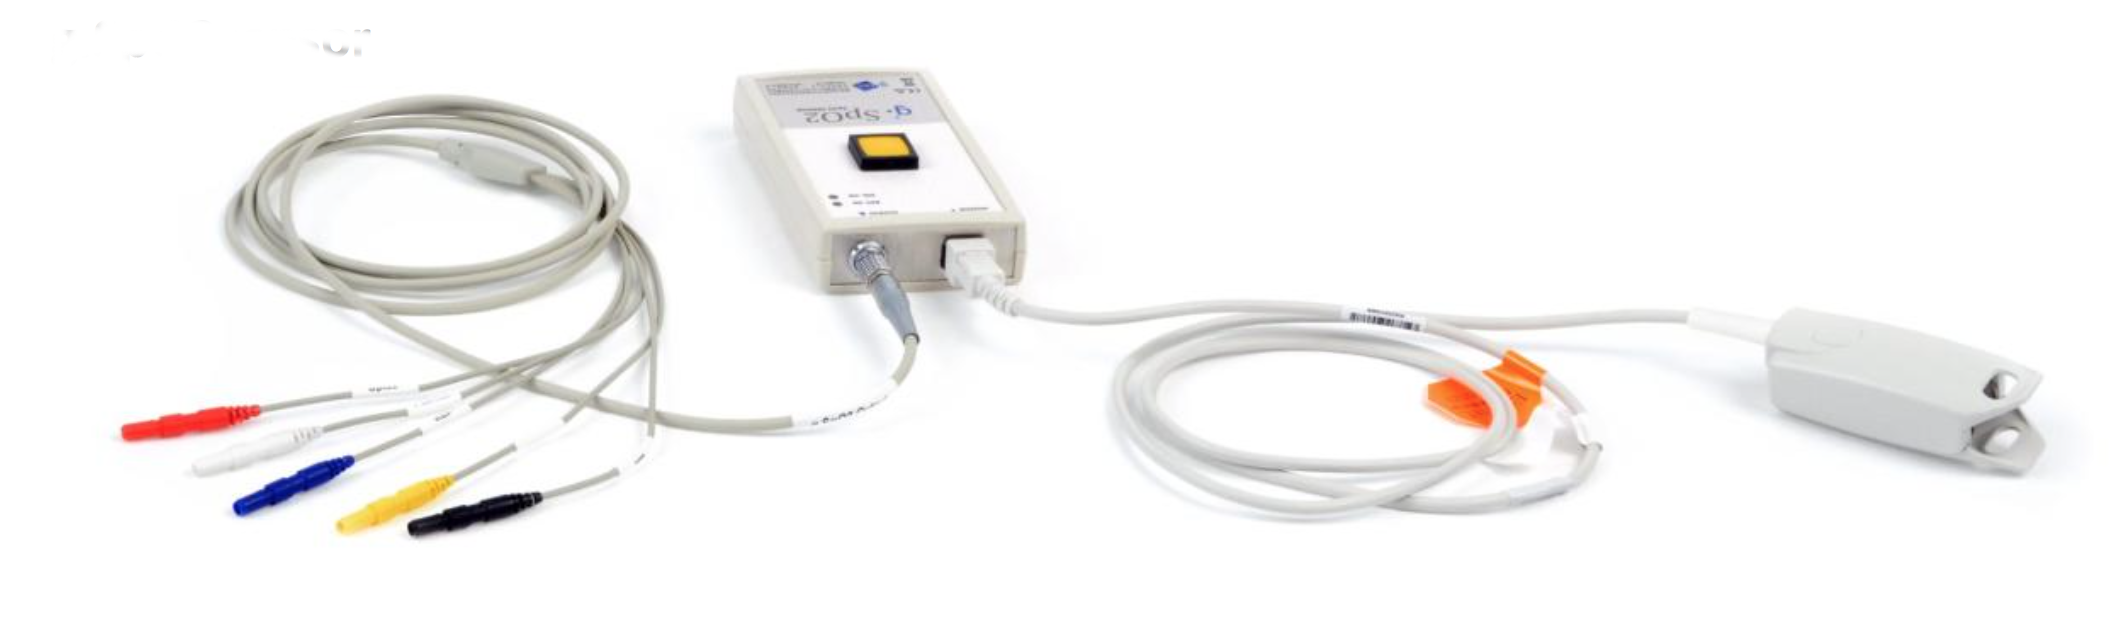

In [18]:
display.Image(filename="images/sensors.png")

## Amplifier and data acquisition

Often they are in the same box.

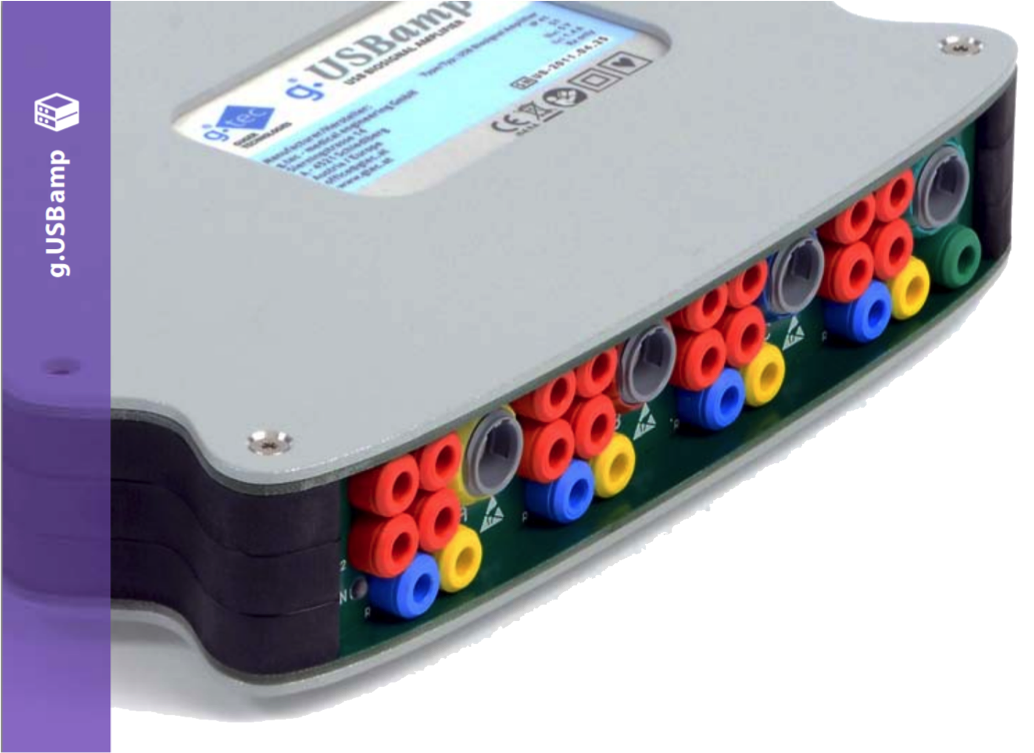

In [19]:
display.Image(filename="images/gusbamp.png")

## Storage media

Often it's a laptop or sometimes some embedded storage like a flash disk


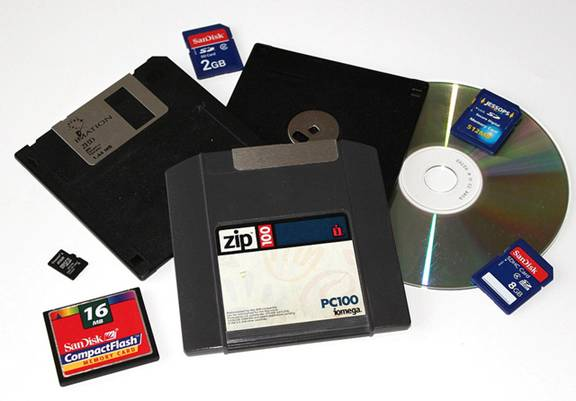

In [20]:
display.Image(filename="images/digital_storage.jpg")

# Salient points on equipment

Sensors
+ Calibrated
+ Sensitive, but not noisy

Amplifier/DAQ
+ Certified for use (CE, FDA) — not strictly necessary for hobbyist use, 
    + _Don't connect hobby tech to mains! Use a battery._
+ High raw sampling rate — oversampling.
+ Low noise, high input impedance.

Storage
+ Make sure it can handle your bandwidth
+ Get lots of it - one minute of ECG uncompressed, ~120Mb (2 x 1024 x 60)

# Storing Biosignals

Large vectors of doubles, some metadata about what we've recorded and feature markers for features we've spotted.

#HDF5!

# HDF5

+ Portable
+ Bindings to everything (C, Fortran, Python, Matlab, Java ... )
+ Supports contiguous or chunked datasets
+ Performant.
+ Good features for storing metadata

# HDF5 in Python

In [2]:
import h5py
import numpy as np

f = h5py.File("ecg.h5", "w")
dset = f.create_dataset("ECG", (1024,), dtype='f')

# HDF5 datasets

Store the raw signal in one dataset, store a processed signal in another.

In [3]:
raw_ECG = f.create_dataset("raw_ECG", (65772,), dtype='f')
normal_ECG = f.create_dataset("normal_ECG", (65772,), dtype='f')
smoothed_ECG = f.create_dataset("smoothed_ECG", (65772,), dtype='f')

# HDF5 groups

Useful for grouping results by subject

In [ ]:
emlyn = f.create_group("subject_emlyn")

# HDF5 attributes
You can store metadata right next to the data it describes! Yay!

In [8]:
normal_ECG.attrs['species'] = 'human'
normal_ECG.attrs['subject'] = 'emlyn'
normal_ECG.attrs['date'] = '12/06/2007'
normal_ECG.attrs['sex'] = 'Yes please'

# Processing biosignals

Essentially it's digital signal processing — same rules apply. Biosignals tends to be continuous, periodic and complex waveforms. 

## Basic <small>a.ka. cleaning the signal</small>
+ Filtering noise
+ Correct the baseline
+ Smoothing

## Advanced <small>a.k.a feature detection</small>
+ Peak detection
+ Wavelet transformations 
+ Morphology analysis

# Basic processing

# Filtering noise

The signal you are looking for is usually between a specific wavelength so you can apply bandpass filters to just focus on the region of interest.

... you can do this with analogue electronics

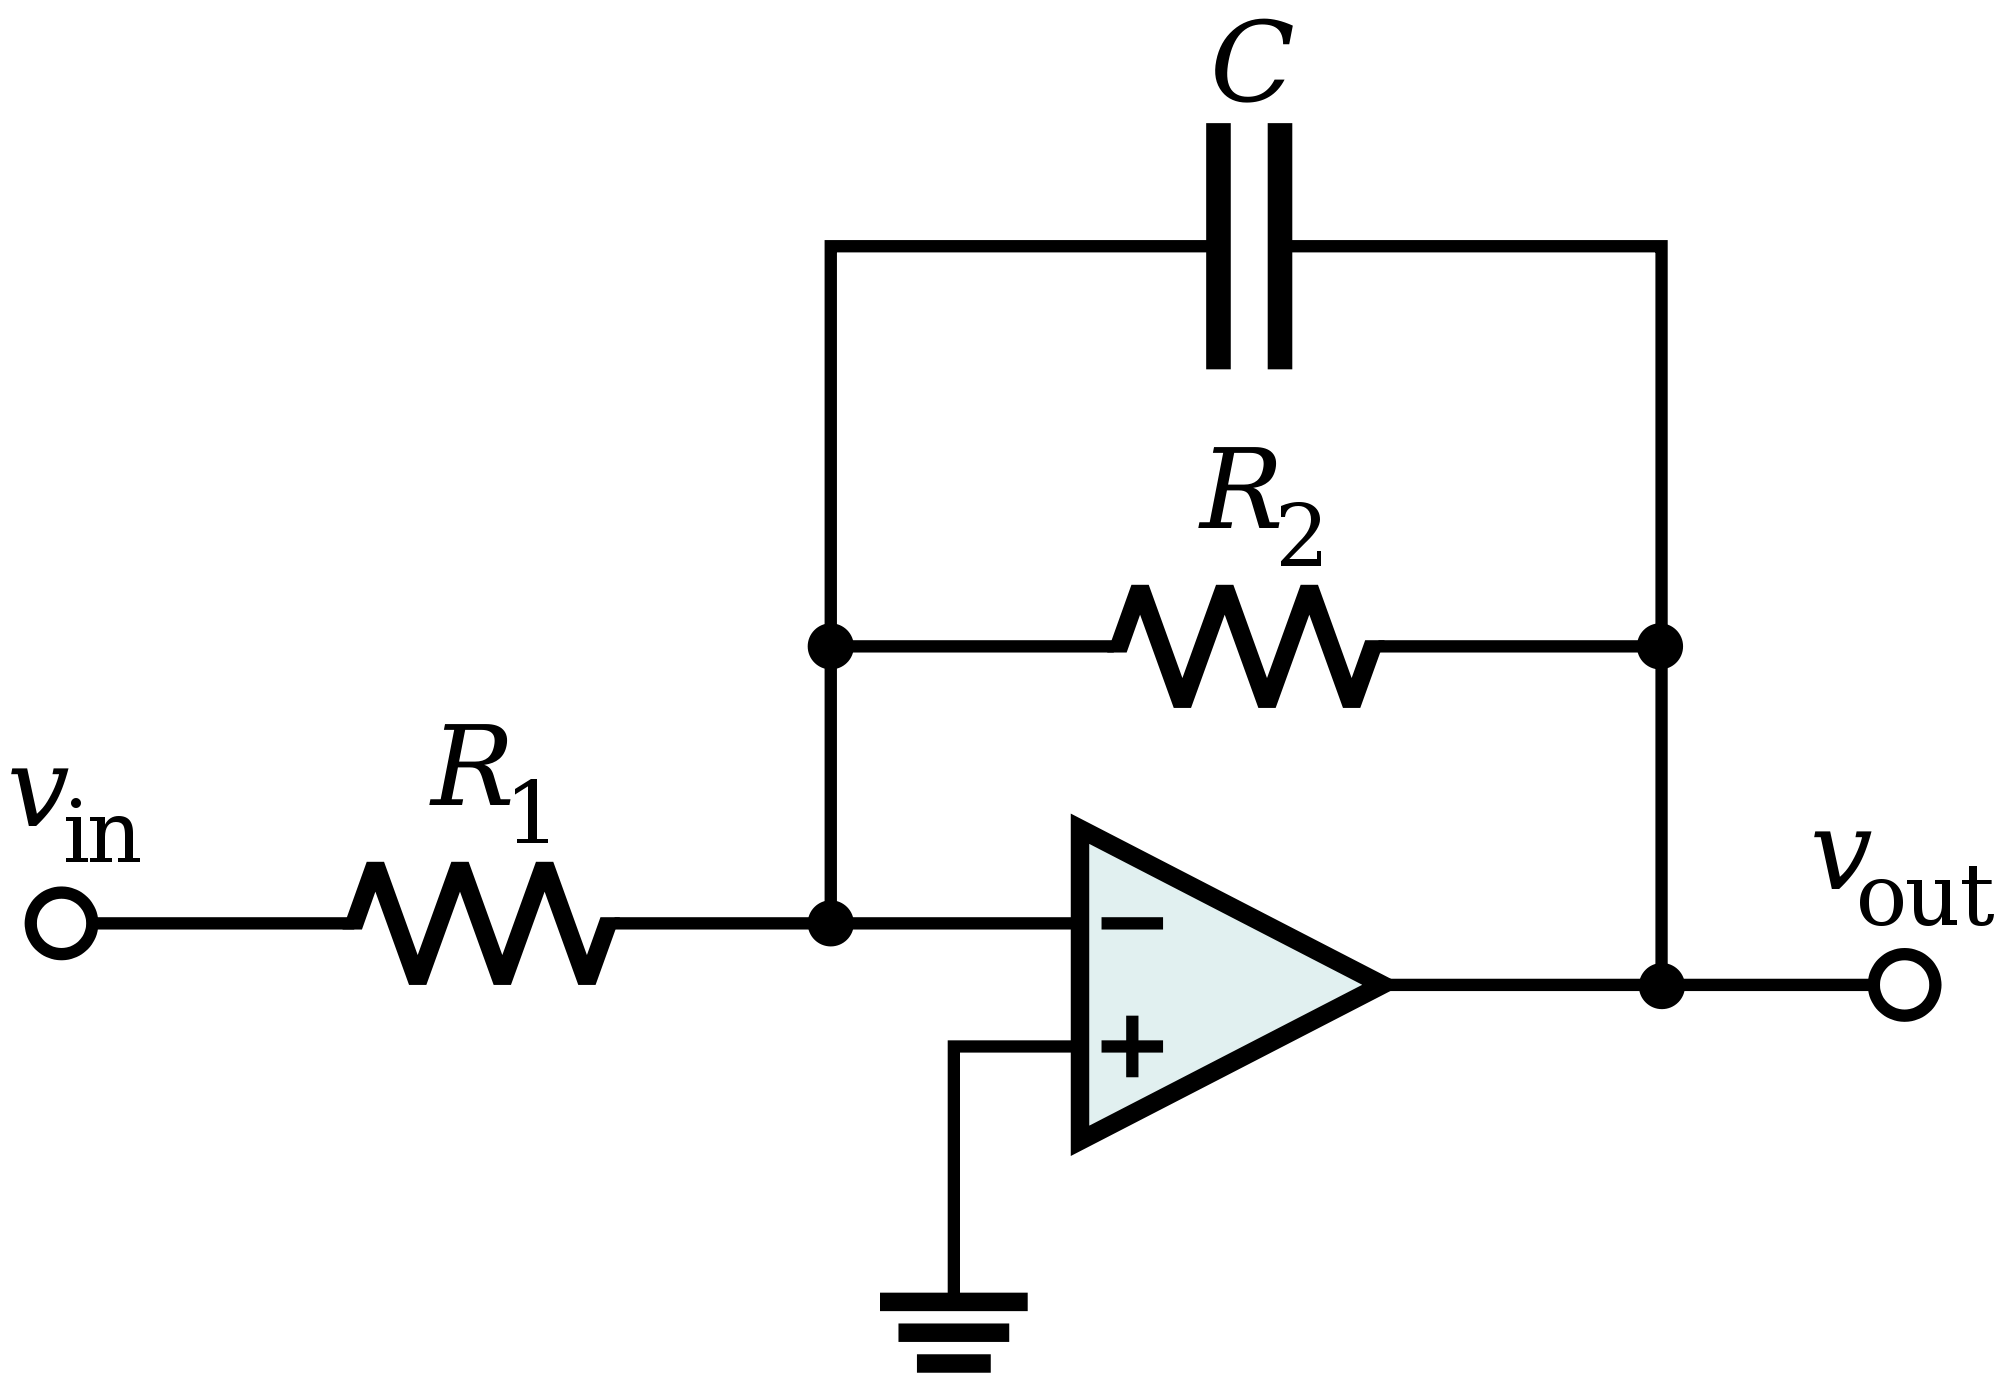

In [18]:
display.Image(filename='images/lowpass_filter.png', width='400px')

... but, then you have to worry about all sorts of compromises due to frequency responses and cut-off definition.

 # Filtering noise with the FFT
 
The grand conceit of Fourier's work was that all sinusoids can be described as a series of sinusoids superimposed on one another.

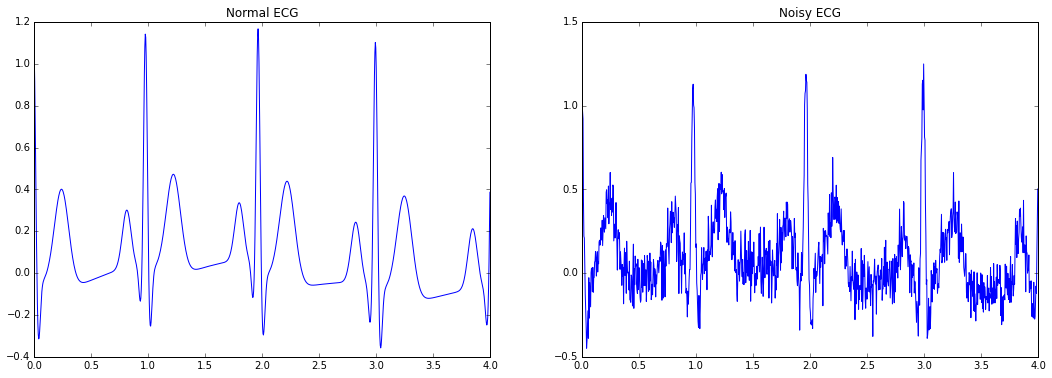

In [3]:
# Load an ECG
samples = 1024
time = np.loadtxt('data/ecgsyn.dat', usecols=(0,))
ecg = np.loadtxt('data/ecgsyn.dat', usecols=(1,))
noise = np.random.normal(0,0.1,samples)

figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

ax1.set_title('Normal ECG')
ax1.plot(time[:samples], ecg[:samples])

# Add some noise
ax2.set_title('Noisy ECG')
ax2.plot(time[:samples], ecg[:samples]+noise)

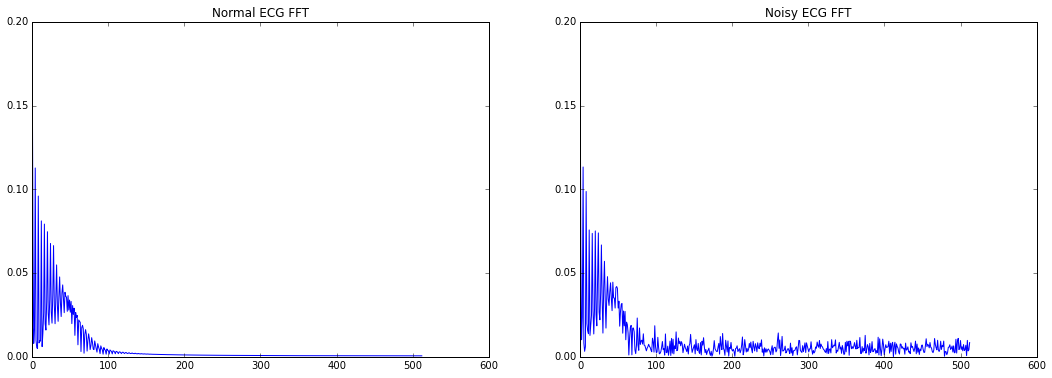

In [4]:
normal_ecg_fft = np.fft.fft(ecg[:samples])
noisy_ecg_fft = np.fft.fft(ecg[:samples]+noise)

figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

freqs = np.linspace(0.0, 1.0/(2.0*(1/samples)), samples/2)

ax1.set_title('Normal ECG FFT')
ax1.plot(freqs, 2.0/samples * np.abs(normal_ecg_fft[0:samples/2]))

ax2.set_title('Noisy ECG FFT')
ax2.plot(freqs, 2.0/samples * np.abs(noisy_ecg_fft[0:samples/2]))

... zero the numbers of the frequencies you don't want and you filter them from the signal.

# Correct a baseline

## ... for quiet signals (ECG)

+ Substract the modal value away from the signal 
+ FFT and filter lower frequency components

## ... for noisy signals (EEG)

+ Substract the mean away from the signal
+ Substract a window mean also.

## ... or it's a trivial point

+ The segment behind the P-wave is the baseline for the ECG
+ The trough of diastole is the baseline for blood pressure

# Smoothing

Noise is often random so a moving-average moving-exponential window are good, but there are caveats. There is a tradeoff between:

+ How smooth the signal is
+ How precise the peaks (and troughs) are

... I often use the Savitzky-Golay smooth with biosignals because it favours maintaining the shape of the signal.

## Introduction to Signal Processing — Smoothing <small>University of Maryland</small>

In [51]:
display.IFrame('http://terpconnect.umd.edu/~toh/spectrum/Smoothing.html', width="100%", height="400px")

# Advanced processing

## Peak detection

Signals have a variety of peaks that often relate to an event.

The strategy is to: 
1. Smooth the signal to reduce local maxima influence
2. Set a treshold height and width
3. Use a moving-window regression to locate peaks

# R-peak detection

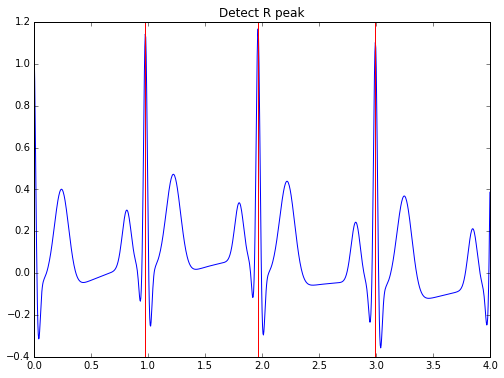

In [22]:
import peakutils # arg! this should be in scipy.signal

peak_index = peakutils.indexes(ecg[:samples], thres=0.4, min_dist=0.1)

figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(121)

ax1.set_title('Detect R peak')
ax1.plot(time[:samples], ecg[:samples])

for peak in peak_index:
    ax1.axvline(x=time[peak], color='r')

# R-peak, P-wave and T-wave detection

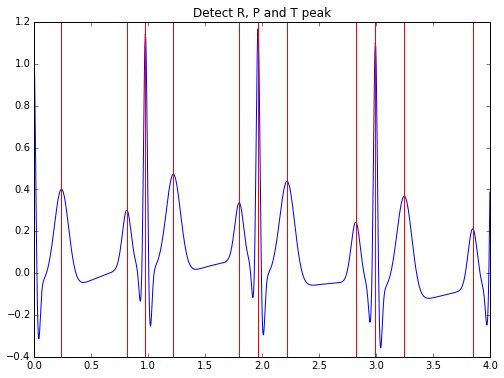

In [25]:
import peakutils

peak_index = peakutils.indexes(ecg[:samples], thres=0.1, min_dist=0.1)

figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(121)

ax1.set_title('Detect R, P and T peak')
ax1.plot(time[:samples], ecg[:samples])

for peak in peak_index:
    ax1.axvline(x=time[peak], color='r')

##  Wavelet transformations

FFT is great, but it isn't very good for telling us about the time-frequency relationship at a given point in time.

### Continuous wavelet

> Continues wavelet transform (CWT) [are] defined as the sum
> over all time of the signal multiplied by scaled, shifted
> versions of the wavelet function Ψ
> <small>Gautum & Kaur, Apr. 2012, Vol. 2(4) pp: 632-635</small>

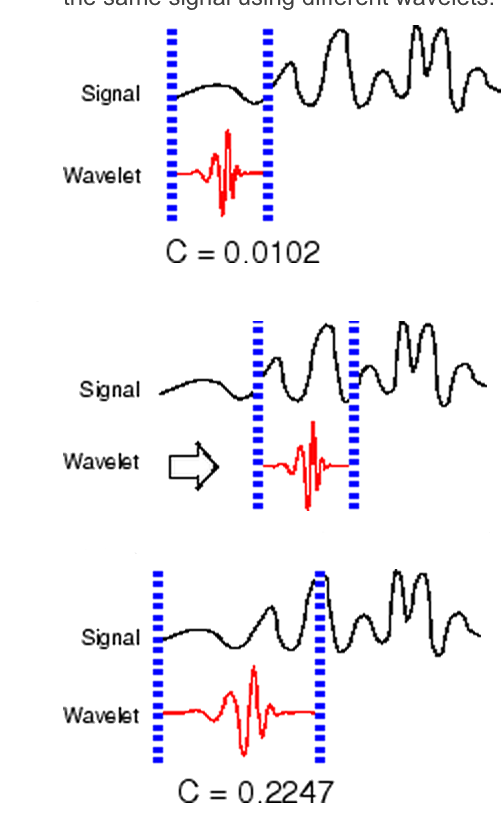

In [39]:
display.Image(filename="images/cwt.png")

Useful article on Continuous Wavelet Transforms: http://uk.mathworks.com/help/wavelet/gs/continuous-wavelet-transform.html

#### Relevance to the ECG

+ They have a much better detection rate of P-waves and T-waves — reduce the need to have a clear cut-off 

## Morphology analysis

The shape and size of particular features can be important.

+ Slope steepness - peak to trough
+ Area under the curve

# Analysing Biosignals

The most involved part of the process by far.

Usually you are looking at changes in the detected features, the information in a biosignal is hardly ever just in the time domain. 

Broadly,

+ Trends — i.e. does heart rate increase or decrease over time.
+ Dose response - i.e. when you eat a doughnut does your blood sugar level go up
+ Periodic effects — i.e. does the frequency of coughing increase in the night

# ECG

Normal characteristics:

Metric                 | Utility
-----------------------|-----------------------------------------------------
Heart Rate Variability | Sign of aging, fitness
Base heart rate        | Healthy individuals tend to have a lower heart rate

Characteristics associated with disease:

Name of abnormality   | Characteristic features 
----------------------|---------------------------------------  
Dextrocardia          | P-wave Inverted
Tachycardia           | R-R interval < 0.6 s
Bradycardia           | R-R interval > 1 s
Hyperkalemia          | Tall T-wave and absence of P-wave
Myocardial ischaemia  | Inverted T-wave
Hypercalcaemia        | QRS interval < 0.1 s
Sinoatrial block      | Complete drop out of a cardiac cycle
Sudden cardiac death  | Irregular ECG

<small>Citation: ECG Detection Using a Convolution Wavelet Algorithm for Denoising of Surface EMG, Yeom et al. (2012)</small>

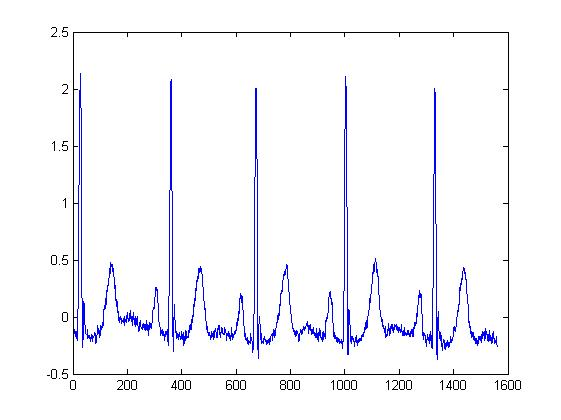

In [11]:
display.Image(filename="images/signal_ecg.jpeg")

# Conclusions

+ Use equipment that's certified for use, or if you can't please don't connect it to mains power.
+ Understanding digital signal processing is key to analysing biosignals
+ Analysing biosignals requires a strong knowledge of physiology

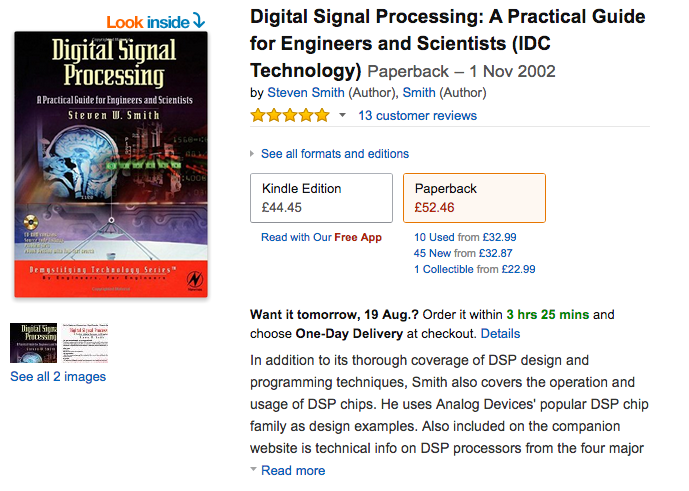

In [26]:
display.Image(filename="images/dsp_book.png")

Also available for *free* as a webpage - http://www.dspguide.com/ 

# Questions?

- Twitter: @emlynclay
- Email: eclay101@gmail.com